In [2]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [ ]:
# the goal here is to create a better way of pre-selecting a pool of transcripts for the tissue
# from within which the samples are going to be generated

# currently, we have way too many transcripts in the tissue pool (while the number of loci is ok)

In [2]:
# let's begin putting together the transcriptome simulation set

# What we need
# number of transcripts to simulate (what is an average number of transcripts per tissue?)
# number of loci (average for a tissue)
# for each locus need to draw the number of transcripts of each category, such that the final distributions
#     are close to tissue averages

# then for each transcript need to draw from the distribution of total contribution to expression
#     such that the final distributions resemble those observed in real data

In [3]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/full_analysis_t3_s10/sim_samples/"

num_tissues = 3

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [4]:
# STAGE - 1 - generating sample specific gtfs

# load base annotations
print(">>>loading base annotations")
real_baseDF = pd.read_csv(base_dir_data+"real.gtf",sep="\t",names=gff3cols)
real_baseDF = real_baseDF[(real_baseDF["type"]=="transcript") & (real_baseDF["strand"].isin(["+","-"]))].reset_index(drop=True)

splice_baseDF = pd.read_csv(base_dir_data+"splicing.gtf",sep="\t",names=gff3cols)
splice_baseDF = splice_baseDF[(splice_baseDF["type"]=="transcript") & (splice_baseDF["strand"].isin(["+","-"]))].reset_index(drop=True)

int_baseDF = pd.read_csv(base_dir_data+"intronic.gtf",sep="\t",names=gff3cols)
int_baseDF = int_baseDF[(int_baseDF["type"]=="transcript") & (int_baseDF["strand"].isin(["+","-"]))].reset_index(drop=True)

pol_baseDF = pd.read_csv(base_dir_data+"RNApol.gtf",sep="\t",names=gff3cols)
pol_baseDF = pol_baseDF[pol_baseDF["type"]=="transcript"].reset_index(drop=True)

>>>loading base annotations


In [5]:
# get all loci and transcript IDs
print(">>>getting loci IDs")
real_baseDF["lid"] = real_baseDF["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splice_baseDF["lid"] = splice_baseDF["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
int_baseDF["lid"] = int_baseDF["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
pol_baseDF["lid"] = pol_baseDF["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
real_locs = set(real_baseDF["lid"])
splice_locs = set(splice_baseDF["lid"])
int_locs = set(int_baseDF["lid"])
pol_locs = set(pol_baseDF["lid"])
print("starting number of real noise loci: "+str(len(real_locs)))
print("starting number of splicing noise loci: "+str(len(splice_locs)))
print("starting number of intronic loci: "+str(len(int_locs)))
print("starting number of polymerase loci: "+str(len(pol_locs)))

>>>getting loci IDs
starting number of real noise loci: 40206
starting number of splicing noise loci: 39058
starting number of intronic loci: 27192
starting number of polymerase loci: 638709


In [6]:
# perform cleanup, by removing any loci in 
#   1. int that are also in real
#   2. splice that are not in real
#   3. pol that are in real
int_locs = int_locs - int_locs.difference(real_locs)
assert(len(int_locs.difference(real_locs))==0),"something wrong intronic"
int_baseDF = int_baseDF[int_baseDF["lid"].isin(int_locs)].reset_index(drop=True)

splice_locs = splice_locs - splice_locs.difference(real_locs)
assert(len(splice_locs) == len(real_locs.intersection(splice_locs))),"something wrong non-intronic"
splice_baseDF = splice_baseDF[splice_baseDF["lid"].isin(splice_locs)].reset_index(drop=True)

pol_locs = pol_locs - real_locs.intersection(pol_locs)
assert(len(real_locs.intersection(pol_locs))==0),"something wrong polymerase"
pol_baseDF = pol_baseDF[pol_baseDF["lid"].isin(pol_locs)].reset_index(drop=True)

real_baseDF["tid"] = real_baseDF["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
real_baseDF = real_baseDF[["lid","tid"]]
splice_baseDF["tid"] = splice_baseDF["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
splice_baseDF = splice_baseDF[["lid","tid"]]
int_baseDF["tid"] = int_baseDF["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
int_baseDF = int_baseDF[["lid","tid"]]
pol_baseDF["tid"] = pol_baseDF["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
pol_baseDF = pol_baseDF[["lid","tid"]]

print("number of real transcripts: "+str(len(real_baseDF["tid"])))
print("number of real genes: "+str(len(set(real_baseDF["lid"]))))

print("number of splicing transcripts: "+str(len(splice_baseDF["tid"])))
print("number of splicing genes: "+str(len(set(splice_baseDF["lid"]))))

print("number of intronic transcripts: "+str(len(int_baseDF["tid"])))
print("number of intronic genes: "+str(len(set(int_baseDF["lid"]))))

print("number of intergenic transcripts: "+str(len(pol_baseDF["tid"])))
print("number of intergenic genes: "+str(len(set(pol_baseDF["lid"]))))

number of real transcripts: 301626
number of real genes: 40206
number of splicing transcripts: 11497993
number of splicing genes: 39058
number of intronic transcripts: 5839526
number of intronic genes: 27192
number of intergenic transcripts: 3109133
number of intergenic genes: 638709


30161.48275862069 2415.8275862068963
31389.793103448275 9445.264367816091


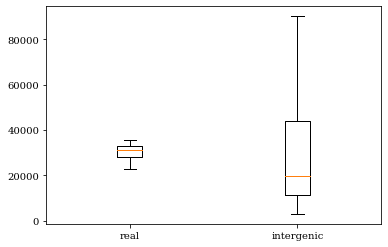

In [7]:
# load the distribution of the number of real and noise loci per tissue first
t_loc = pd.read_csv(base_dir_out+"res.num_locs_tissue")

# now we shall remove any outliers from the data
q25,q50,q75 = t_loc['real'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["real"]<=thw]["real"].max()
alw = t_loc[t_loc["real"]>=tlw]["real"].min()
t_loc = t_loc[(t_loc['real']<=ahw)&(t_loc['real']>=alw)]

q25,q50,q75 = t_loc['intergenic'].quantile([0.25,0.5,0.75])
iqr = q75-q25
thw = q75+1.5*iqr
tlw = q25-1.5*iqr
ahw = t_loc[t_loc["intergenic"]<=thw]["intergenic"].max()
alw = t_loc[t_loc["intergenic"]>=tlw]["intergenic"].min()
t_loc = t_loc[(t_loc['intergenic']<=ahw)&(t_loc['intergenic']>=alw)]

std_real = (t_loc["real"].mean()-t_loc["real"].min())/3
std_intergenic = (t_loc["intergenic"].mean()-t_loc["intergenic"].min())/3
print(t_loc["real"].mean(),std_real)
print(t_loc["intergenic"].mean(),std_intergenic)

fig,ax = plt.subplots()
ax.boxplot(t_loc.T,labels=t_loc.T.index.tolist())
plt.show()

In [8]:
for tissue_num in range(num_tissues):
    print("\n=================\nTissue #"+str(tissue_num)+"\n=================\n")
    # instead of sampling from the actual values we can get it from a distribution (assuming 2 independent gaussians)
    ctlr = int(np.random.normal(t_loc["real"].mean(),std_real,1)[0])
    ctln = int(np.random.normal(t_loc["intergenic"].mean(),std_intergenic,1)[0])

    print("selecting "+str(ctlr)+" real loci")
    print("selecting "+str(ctln)+" intergenic loci")
    
    all_real_locs = real_locs.union(splice_locs.union(int_locs))
    print("number of all real loci: "+str(len(all_real_locs)))

    all_real_locs_rand = np.random.choice(list(all_real_locs),ctlr, replace=False)
    pol_locs_rand = np.random.choice(list(pol_locs),ctln, replace=False)

    real_baseDF_sub1 = real_baseDF[real_baseDF["lid"].isin(all_real_locs_rand)].reset_index(drop=True)
    splice_baseDF_sub1 = splice_baseDF[splice_baseDF["lid"].isin(all_real_locs_rand)].reset_index(drop=True)
    int_baseDF_sub1 = int_baseDF[int_baseDF["lid"].isin(all_real_locs_rand)].reset_index(drop=True)
    pol_baseDF_sub1 = pol_baseDF[pol_baseDF["lid"].isin(pol_locs_rand)].reset_index(drop=True)

    real_baseDF_sub1.to_csv(out_dir+"stage1_tissue_locs.real_t"+str(tissue_num),index=False)
    splice_baseDF_sub1.to_csv(out_dir+"stage1_tissue_locs.splice_t"+str(tissue_num),index=False)
    int_baseDF_sub1.to_csv(out_dir+"stage1_tissue_locs.int_t"+str(tissue_num),index=False)
    pol_baseDF_sub1.to_csv(out_dir+"stage1_tissue_locs.pol_t"+str(tissue_num),index=False)

    print("number of real transcripts: "+str(len(real_baseDF_sub1["tid"])))
    print("number of real genes: "+str(len(set(real_baseDF_sub1["lid"]))))

    print("number of splicing transcripts: "+str(len(splice_baseDF_sub1["tid"])))
    print("number of splicing genes: "+str(len(set(splice_baseDF_sub1["lid"]))))

    print("number of intronic transcripts: "+str(len(int_baseDF_sub1["tid"])))
    print("number of intronic genes: "+str(len(set(int_baseDF_sub1["lid"]))))

    print("number of intergenic transcripts: "+str(len(pol_baseDF_sub1["tid"])))
    print("number of intergenic genes: "+str(len(set(pol_baseDF_sub1["lid"]))))


Tissue #0

selecting 31218 real loci
selecting 29016 intergenic loci
number of all real loci: 40206
number of real transcripts: 234697
number of real genes: 31218
number of splicing transcripts: 8916670
number of splicing genes: 30323
number of intronic transcripts: 4507952
number of intronic genes: 21180
number of intergenic transcripts: 148704
number of intergenic genes: 29016

Tissue #1

selecting 29592 real loci
selecting 39563 intergenic loci
number of all real loci: 40206
number of real transcripts: 223113
number of real genes: 29592
number of splicing transcripts: 8510062
number of splicing genes: 28777
number of intronic transcripts: 4339048
number of intronic genes: 20000
number of intergenic transcripts: 182621
number of intergenic genes: 39563

Tissue #2

selecting 25849 real loci
selecting 23659 intergenic loci
number of all real loci: 40206
number of real transcripts: 192745
number of real genes: 25849
number of splicing transcripts: 7317687
number of splicing genes: 2511